In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision import models, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
f = open("data/dataset_info.txt", "r")
labels = f.readlines()[1:]
f.close()

name_label = {}
lb_list = []

for i in range(len(labels)):
    lb = labels[i].replace("\n", "").strip().split(". ")[1]
    lb_list.append(lb)
    name_label[lb] = 0
    
for i in range(len(lb_list)):
    name_label[lb_list[i]] += i
    
label_name = list(name_label.keys())


In [3]:
class LoadImageDataset(Dataset):
    def __init__(self, imgname_labels_file, img_dir, transform_data = None, typee = 'train',train = True):
        self.df_imgname_labels = pd.read_csv(imgname_labels_file)
        self.df_imgname_labels = shuffle(self.df_imgname_labels)
        if(typee == 'train'):
            self.df_imgname_labels = self.df_imgname_labels[:9000]
        if(typee == 'val'):
            self.df_imgname_labels = self.df_imgname_labels[9000:]
        
        
        self.img_dir = img_dir
        self.transform_data =  transform_data
        self.train = train
        
    def __len__(self):
        return len(self.df_imgname_labels)
    
    def __getitem__(self, idx):
        path = self.img_dir + self.df_imgname_labels.iloc[idx, 0]
        img =  read_image(path)/ 255.
        result = {"image": img, "label": -1}
        if self.train:
            lb = self.df_imgname_labels.iloc[idx, 1]
            result["label"] = lb
            if self.transform_data:
                result["label"] = self.transform_data['labels'](result["label"])
                result["image"] = self.transform_data['images'](result["image"])
        else:
            lb = 0
            result["label"] = lb
            if self.transform_data: 
                result["image"] = self.transform_data['images'](result["image"])
        
        return result

## Basic Network

In [4]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
        )
    def forward(self, x):
        return self.model(x)

In [9]:
def train(path = "data/", batch_size = 8, epochs = 20):
    loss_arr = []
    val_loss_arr = []
     
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print("Using {} device".format(device))
    model = MyNetwork().to(device)
    print(model)
    
    transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y])
                ])
    }
   
    train_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data, typee='train'), batch_size = batch_size,  num_workers=2, shuffle=True)
    val_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data, typee='val'), batch_size = batch_size,  num_workers=2, shuffle=True)
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    for epoch in range(epochs):
        total_loss = 0
        val_loss = 0
        
        for  dic in train_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            # forward pass
            y_preds = model(X)
            loss = loss_fun(y_preds, y)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        for  dic in val_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            y_preds = model(X)
            loss = loss_fun(y_preds, y)
            val_loss += loss.item()
       
        total_loss /= len(train_dataloader.dataset)
        val_loss /= len(val_dataloader.dataset)
        loss_arr.append(total_loss)
        val_loss_arr.append(val_loss)
        
        print("Epoch: "+ str(epoch+1) + " | loss: "+str(total_loss) + " | val loss: "+str(val_loss), flush = True)
    
    return loss_arr, val_loss_arr


def plot(loss_arr, val_loss_arr):
    ind = np.arange(1, len(loss_arr)+1)
    plt.plot(ind, np.array(loss_arr))
    plt.plot(ind, np.array(val_loss_arr))
    plt.legend(['Train', 'Val'], loc='upper left')


In [6]:
epochs = 10
loss_arr, val_loss_arr = train(epochs = epochs)


Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.43115785341792634 | val loss: 0.3737389801456463
Epoch: 2 | loss: 0.37449978870815703 | val loss: 0.32677863367570814
Epoch: 3 | loss: 0.32447120016151004 | val loss: 0.25530038677132905
Epoch: 4 | loss: 0.253207004348437 | val loss: 0.16260207760444736
Epoch: 5 | loss: 0.15011330659190814 | val loss: 0.09886328124040421
Epoch: 6 | loss: 0.07330350698220234 | val loss: 0.06512524584025699
Epoch: 7 | l

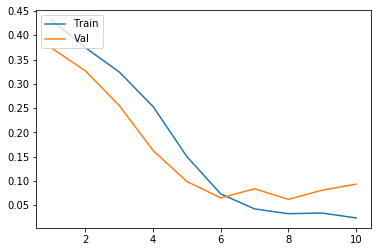

In [17]:
plot(loss_arr, val_loss_arr)

## Playing with layers

### Add BatchNorm

In [10]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 6),
            nn.MaxPool2d(kernel_size = (4,4)),
           
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 16),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
        )
    def forward(self, x):
        return self.model(x)

In [12]:
def plot(loss_arr, val_loss_arr):
    ind = np.arange(1, len(loss_arr)+1)
    plt.plot(ind, np.array(loss_arr))
    plt.plot(ind, np.array(val_loss_arr))
    plt.legend(['Train', 'Val'], loc='upper left')

Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.43840400060017903 | val loss: 0.38590429810916677
Epoch: 2 | loss: 0.37782835817337035 | val loss: 0.35839655672433574
Epoch: 3 | loss: 0.35302804372045726 | val loss: 0.32978825118888644
Epoch: 4 | loss: 0.32969096252653335 

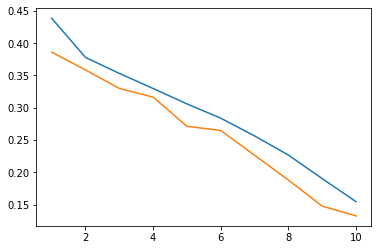

In [11]:
epochs = 10
loss_arr, val_loss_arr = train(epochs = epochs)

    
plot(loss_arr, val_loss_arr)

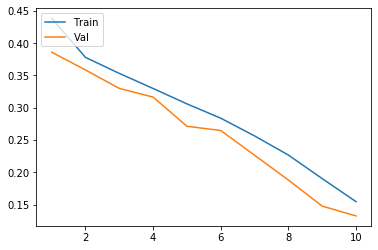

In [13]:
plot(loss_arr, val_loss_arr)

### Max-pool 

Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.42873276201883953 | val loss: 0.3876085547101756
Epoch: 2 | loss: 0.37204592349794174 | val loss: 0.3464291763748547
Epoch: 3 | loss: 0.3301573458181487 | val loss: 0.28066846645284366
Epoch: 4 | loss: 0.27537110828359923 | val loss: 0.19500990622552924
Epoch: 5 | loss: 0.20136767445670234 | val loss: 0.13830653063653053
Epoch: 6 | loss: 0.12743693989970617 | val loss: 0.07076746013142377
Epoch: 7 | l

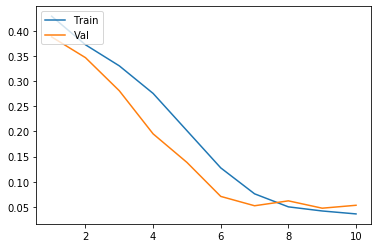

In [21]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
           
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
        )
    def forward(self, x):
        return self.model(x)

epochs = 10
loss_arr, val_loss_arr = train(epochs = epochs)
plot(loss_arr, val_loss_arr)

### Avg Pool

Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.4323432862361272 | val loss: 0.3757481892411554
Epoch: 2 | loss: 0.37942390710777707 | val loss: 0.3360195344446613
Epoch: 3 | loss: 0.34041985796557533 | val loss: 0.2829319574515517
Epoch: 4 | loss: 0.2851017156905598 | val loss: 0.2053627560013219
Epoch: 5 | loss: 0.20402453989452785 | val loss: 0.12011269925179496
Epoch: 6 | loss: 0.1160483955591917 | val loss: 0.07556830324670848
Epoch: 7 | loss: 0.06706186011744042 | val loss: 0.05351358137148268
Epoch

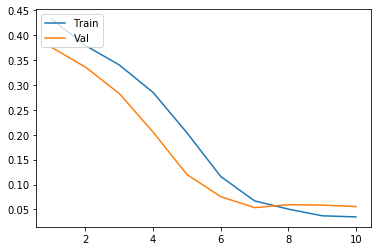

In [6]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
           
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
        )
    def forward(self, x):
        return self.model(x)

epochs = 10
loss_arr, val_loss_arr = train(epochs = epochs)
plot(loss_arr, val_loss_arr)

### Dropout

In [13]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
        )
    def forward(self, x):
        return self.model(x)

Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=1024, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=1024, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.4374965315262477 | val loss: 0.4274996006082824
Epoch: 2 | loss: 0.38711130575339 | val loss: 0.38270262446565895
Epoch: 3 | loss: 0.3500419602261649 | val loss: 0.3380419001121639
Epoch: 4 | loss: 0.3011309941013654 | val loss: 0.26708809694638563
Epoch: 5 | loss: 0.2421791818837324

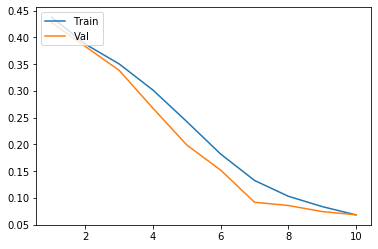

In [14]:
epochs = 10
loss_arr, val_loss_arr = train(epochs = epochs)
plot(loss_arr, val_loss_arr)

### **With Batch Norm**
* Batch normalization regularizes the network which prevents overfitting.
* Helps in resolving vanishing gradient problem.
* Faster convergences and better performance.


### **Adding new layers**
* Might increase perfomance (as visible from loss graphs)
* Chances of overfitting.


### **With Dropout**
* Regulation method.
* Reduces overfitting.
* Drop some of neurons randomly.
* Improved loss in some cases as shown.

### **Different activation functions at the end**
* **Softmax**
 $$\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)} $$
    * Used in Multi-class classification.
    * Softmax activation gives a probability distribution (the outputs sum to one and each output is between 0-1)
    * Thus we use Softmax at end layer when class labels are mutually exclusive(which is in our case!)

    
    
<!-- * **KL Divergence**
![caption](attachments/KL.png)
    * Measures distance between probability distributions.

     -->
    
Note: Sigmoid is used in binary classification (hence can'nt be used in our case)
 $$ h_ \theta (x) = \frac{\mathrm{1} }{\mathrm{1} + e^- \theta^Tx }$$

* Leaky ReLU and ReLU were tried in between layers. Leaky Relu helps prevent vanishing gradient problem and thus helped in loss.


### **Different pooling strategies**
* **Max pooling**
    * Max pooling is a sample-based discretization process. 
    * Used to reduce dimensionality of feature maps.
    * Takes max operator over sliding window.
* **Avg Pooling**
    * Takes Avg operator over sliding window.
    
Max pooling was found to perfom better.

### **Different optimizers**
* **SGD**
    * Stochastic Gradience Descent
    * Suffers from vanishing gradient problem.
    
* **RMSProp**
    * Helps in vanishing gradient.
    * Uses an adaptive learning rate
    * Uses a moving average of squared gradients to normalize the gradient. 
    * This normalization balances the step size  (momentum)
    * Decreases the step for large gradients to avoid exploding
    * Increases the step for small gradients to avoid vanishing. 

* **Adagrad (Adaptive Gradient Algorithm)**
    * For a sparse feature input where most of the values are zero, we can afford a higher learning rate which will boost the dying gradient resulted from these sparse features. If we have dense data, then we can have slower learning. 
    * Adjusts the learning rate according to values of gradient incurred.
    * When larger updates take smaller learning rate.
    * When smaller updates increase learning rate.

* **Adam**
    * Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
    * Adam is relatively easy to configure where the default configuration parameters do well on most problems.
    
 
SGD Could'nt converge well.

We observed the best convergence and model performance in Adam.


   

### **Basic Augmentation like Rotation, Translation, Color Change**
* Augmentation is used to add robustness to the train data. 
* Helps to improve the performance of model.



## Bonus
### Residual Blocks
### Different learning strategies
### CutMix Augmentation